In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Line Class

In [34]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # previous line predictions
        self.recent_xfitted_left = [] 
        self.recent_xfitted_right = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx_left = None   
        self.bestx_right = None   
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 

Calibrating Camera

In [35]:
import glob
images = glob.glob("camera_cal/calibration*.jpg")
objectpoint = []
imagepoints = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0
                      :6].T.reshape(-1,2)
for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret == True:
        imagepoints.append(corners)
        objectpoint.append(objp)
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoint, imagepoints, gray.shape[::-1], None, None)

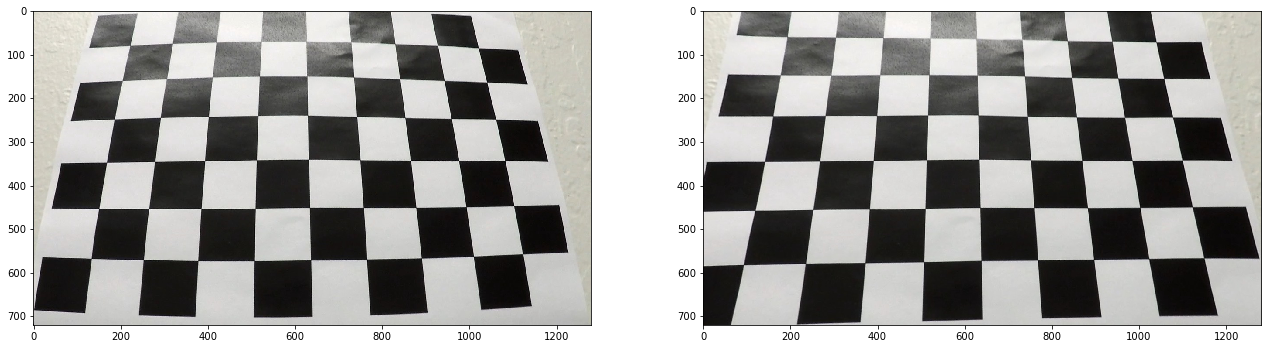

In [36]:
img1  = mpimg.imread("camera_cal/calibration3.jpg")       
dst = cv2.undistort(img1, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,16))
ax1.imshow(img1)
ax2.imshow(dst)

Helper Functions of Thresholding Image

In [37]:
def dist_corct(img,mtx,dist):
    undistorted_image = cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted_image

def abs_sobel_thresh(img, orient='x',sobel_kernel=9, abs_thresh=(90,200)):
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=9, mag_thresh=(90,200)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    return binary_output
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
def hls_select_s(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    imghls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(imghls[:,:,2])
    binary_output[(imghls[:,:,2]>thresh[0]) & (imghls[:,:,2]<=thresh[1])] = 1
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    return binary_output
def hls_select_l(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    imghls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(imghls[:,:,1])
    binary_output[(imghls[:,:,1]>thresh[0]) & (imghls[:,:,1]<=thresh[1])] = 1
    # 2) Apply a threshold to the L channel
    # 3) Return a binary image of threshold result
    return binary_output
def perp_transform(img):
    img_size = (img.shape[1],img.shape[0])
    # Definign src and destination points for transsformation
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M,img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

Correct Distortion for all test images

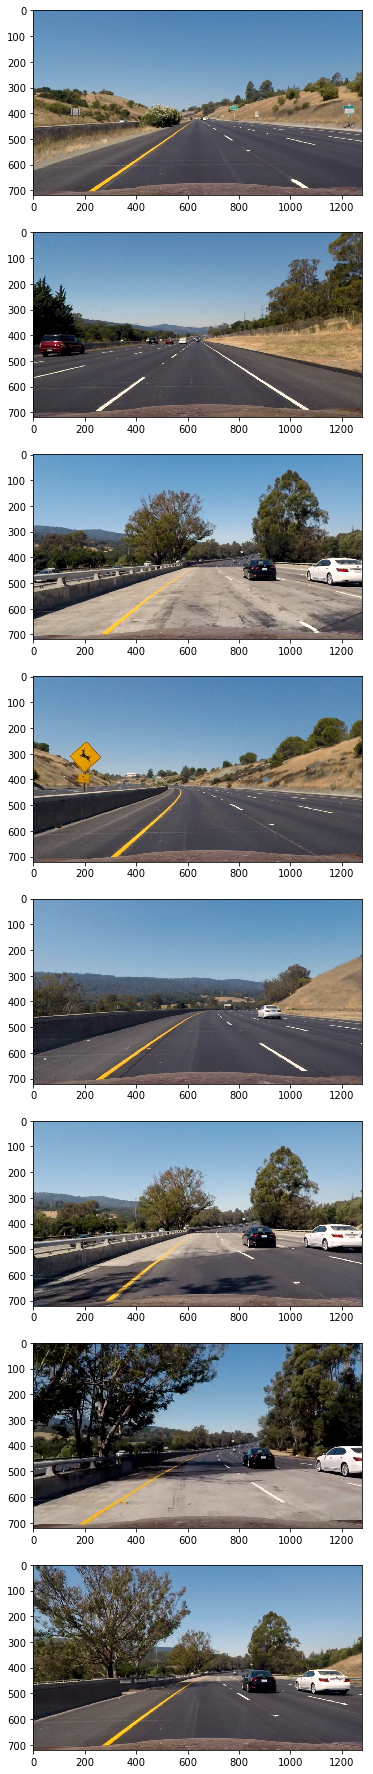

In [38]:
test_images = glob.glob("test_images/*.jpg")
undist_images = []
for img in test_images:
    img = mpimg.imread(img)        
    img = dist_corct(img,mtx,dist)
    undist_images.append(img)
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(50,32))
ax1.imshow(undist_images[0])
ax2.imshow(undist_images[1])
ax3.imshow(undist_images[2])
ax4.imshow(undist_images[3])
ax5.imshow(undist_images[4])
ax6.imshow(undist_images[5])
ax7.imshow(undist_images[6])
ax8.imshow(undist_images[7])

Gradient Thresholding and Color thresholding Visualization

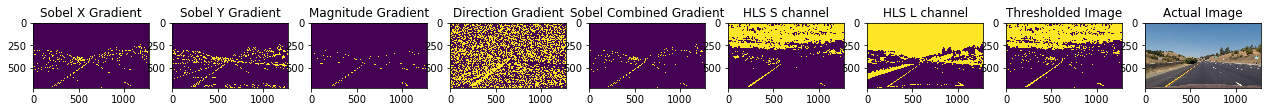

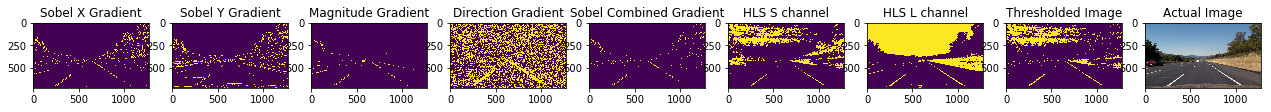

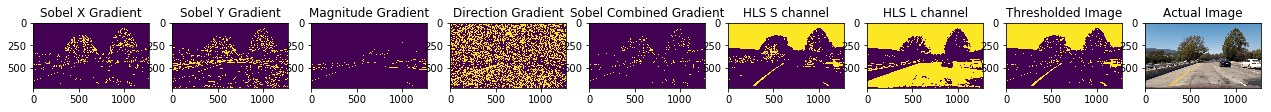

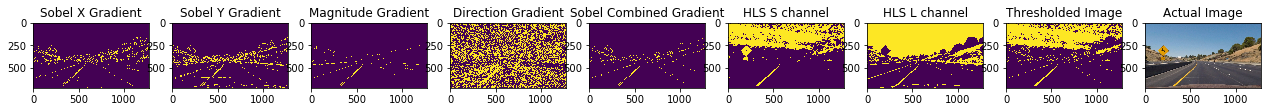

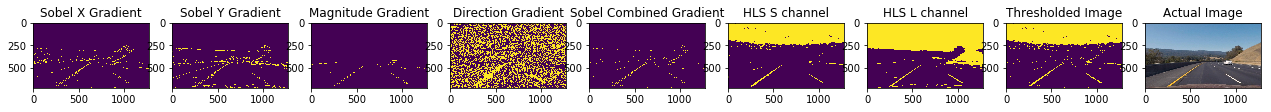

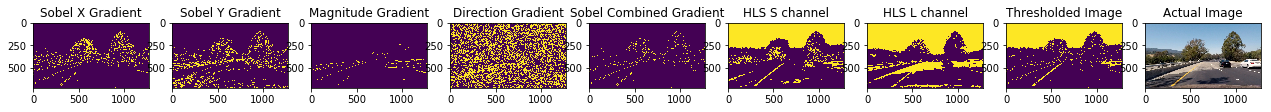

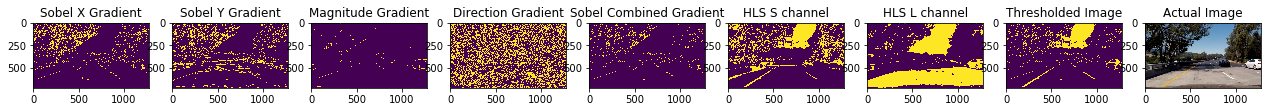

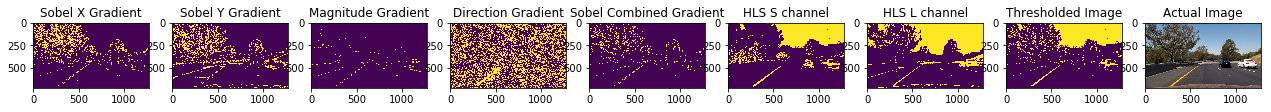

In [39]:
# Apply each of the thresholding functions
f_thresh_images = []
for img in undist_images:
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=21, abs_thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=9, abs_thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(100, 190))
    dir_binary = dir_threshold(img, sobel_kernel=19, thresh=(0.7,  1.3)) 
    hls_binary_s = hls_select_s(img, thresh=(100, 255))
    hls_binary_l = hls_select_l(img, thresh=(120,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(combined)
    combined_binary[(combined == 1) | ((hls_binary_s == 1) & (hls_binary_l == 1))] = 1
    f_thresh_images.append(combined_binary)
    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8, ax9) = plt.subplots(1, 9, figsize=(22,16))
    ax1.imshow(gradx)
    ax1.set_title("Sobel X Gradient")
    ax2.imshow(grady)
    ax2.set_title("Sobel Y Gradient")
    ax3.imshow(mag_binary)
    ax3.set_title("Magnitude Gradient")
    ax4.imshow(dir_binary)
    ax4.set_title("Direction Gradient")
    ax5.imshow(combined)
    ax5.set_title("Sobel Combined Gradient")
    ax6.imshow(hls_binary_s)
    ax6.set_title("HLS S channel")
    ax7.imshow(hls_binary_l)
    ax7.set_title("HLS L channel")
    ax8.imshow(combined_binary)
    ax8.set_title("Thresholded Image")
    ax9.imshow(img)      
    ax9.set_title("Actual Image")

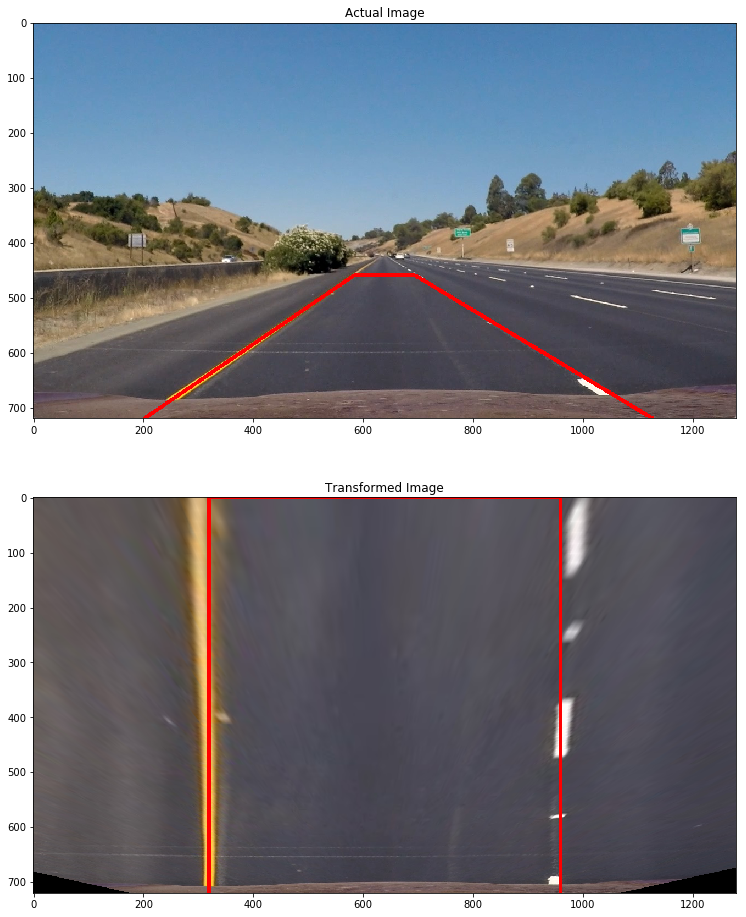

In [40]:
testImg = mpimg.imread("test_images/straight_lines1.jpg")
prsp_tr,x = perp_transform(testImg)
cv2.line(testImg,(203, 720),(585, 460),(255,0,0),5)
cv2.line(testImg,(585, 460),(695, 460),(255,0,0),5)
cv2.line(testImg,(695, 460),(1127, 720),(255,0,0),5)
cv2.line(prsp_tr,(320, 720),(320, 0),(255,0,0),5)
cv2.line(prsp_tr,(320, 0),(960, 0),(255,0,0),5)
cv2.line(prsp_tr,(960, 0),(960, 720),(255,0,0),5)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(22,16))
ax1.imshow(testImg)
ax1.set_title("Actual Image")
ax2.imshow(prsp_tr)
ax2.set_title("Transformed Image")

In [41]:
trnsformed_img = []
Minv_array = []
for img in f_thresh_images:
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    Minv_array.append(Minv)
    warped = cv2.warpPerspective(img, M,img_size, flags=cv2.INTER_LINEAR)
    trnsformed_img.append(warped)

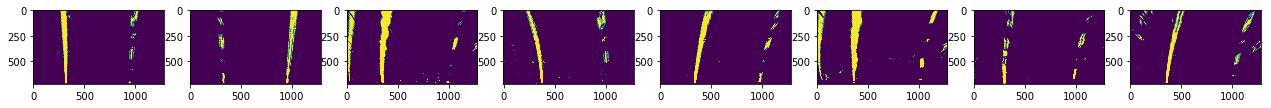

In [42]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8) = plt.subplots(1, 8, figsize=(22,16))
ax1.imshow(trnsformed_img[0])
ax2.imshow(trnsformed_img[1])
ax3.imshow(trnsformed_img[2])
ax4.imshow(trnsformed_img[3])
ax5.imshow(trnsformed_img[4])
ax6.imshow(trnsformed_img[5])
ax7.imshow(trnsformed_img[6])
ax8.imshow(trnsformed_img[7])        

Visualizing Window search algorithm for finding out polynomial fit

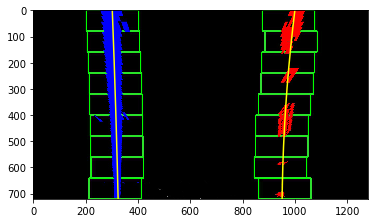

In [44]:
binary_warped = trnsformed_img[0]
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
cv2.imwrite('vis.jpg', out_img)
out_img = mpimg.imread('vis.jpg')
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)

Building Functions for finding polynomial fit

In [5]:
# Function for performing a complete windopw search and findind polynomial fit along with radius of curvature
def fitpolyfirst(img):
    binary_warped = img
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[(binary_warped.shape[0]//2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Measuring the radius of curvature
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = binary_warped.shape[0]-1
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_fit,right_fit,left_curverad,right_curverad

#Function for finding new polynomial fit values utilizing he polynomial fit of the previous frame along with radius of curvature
def fitpoly(binary_warped,left_fit,right_fit):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Measuring the radius of curvature
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = binary_warped.shape[0]-1
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fit,right_fit,left_curverad,right_curverad

Testing pipeline on test images

In [6]:
test_images = glob.glob("test_images/*.jpg")
results = []
index = 0
left_right_fit_previous =[]
for img in test_images:
    img = mpimg.imread(img)   
    # Apply all the thresholds and perpective transform to the image
    undist_image = dist_corct(img,mtx,dist)
    gradx = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=21, abs_thresh=(20, 100))
    grady = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=9, abs_thresh=(20, 100))
    mag_binary = mag_thresh(undist_image, sobel_kernel=9, mag_thresh=(100, 190))
    dir_binary = dir_threshold(undist_image, sobel_kernel=19, thresh=(0.7,  1.3)) 
    hls_binary_s = hls_select_s(undist_image, thresh=(100, 255))
    hls_binary_l = hls_select_l(undist_image, thresh=(120,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(combined)
    combined_binary[(combined == 1) | ((hls_binary_s == 1) & (hls_binary_l == 1))] = 1
    binary_warped,Minv = perp_transform(combined_binary)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit,right_fit,x,y = fitpolyfirst(binary_warped)
    left_right_fit_previous =[left_fit,right_fit]
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    #Display average curvature of left and right lane
    curv = (x+y)/2
    curvature = "Radius of curvature: %.2f m" % curv
    cv2.putText(result,curvature , (100, 90), cv2.FONT_ITALIC, 1.5, (0,0,0), thickness=3)
    
    # Calculate the vehicle position with respect to center
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    x_max = undist_image.shape[1]
    img_center = x_max/2
    left_start = left_fitx[719]
    right_start = right_fitx[719]
    center_lane = (left_start + right_start)/2
    vehicle_cen = img_center - center_lane
    vehicle_cen = vehicle_cen * xm_per_pix
    if vehicle_cen<0:
        vehicle_center = "Center of Vehicle: Right %.2f m" % abs(vehicle_cen)
    else:
        vehicle_center = "Center of Vehicle: Left %.2f m" % abs(vehicle_cen)
    cv2.putText(result,vehicle_center , (100, 180), cv2.FONT_ITALIC, 1.5, (0,0,0), thickness=3)
    results.append(result) 
    
    

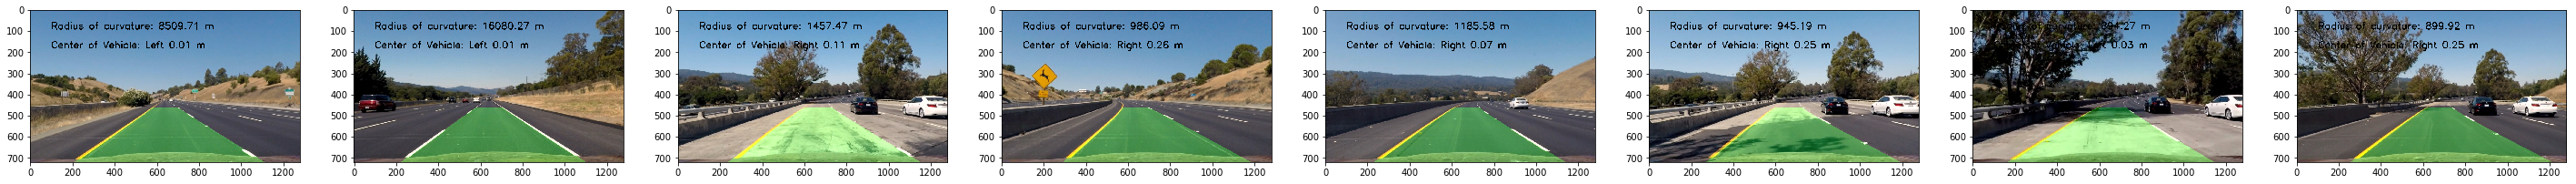

In [7]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8) = plt.subplots(1, 8, figsize=(50,32))
ax1.imshow(results[0])
ax2.imshow(results[1])
ax3.imshow(results[2])
ax4.imshow(results[3])
ax5.imshow(results[4])
ax6.imshow(results[5])
ax7.imshow(results[6])
ax8.imshow(results[7])  

In [8]:
# Create a Line object
line_object = Line()

In [9]:
# Calculate average of the last 10 lines
def line_average(linex,liney):
    if len(line_object.recent_xfitted_left) <10 :
        line_object.recent_xfitted_left.append(linex)
    else:
        line_object.recent_xfitted_left.append(linex)
        linex = sum(line_object.recent_xfitted_left[-10:])/10
    if len(line_object.recent_xfitted_right) <10 :
        line_object.recent_xfitted_right.append(liney)
    else:
        line_object.recent_xfitted_right.append(liney)
        liney = sum(line_object.recent_xfitted_right[-10:])/10
    return linex, liney

Pipeline fo Video

In [10]:

def process_image(img):
    # Apply all the thresholds and perpective transform to the image
    undist_image = dist_corct(img,mtx,dist)
    gradx = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=21, abs_thresh=(20, 100))
    grady = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=9, abs_thresh=(20, 100))
    mag_binary = mag_thresh(undist_image, sobel_kernel=9, mag_thresh=(100, 190))
    dir_binary = dir_threshold(undist_image, sobel_kernel=19, thresh=(0.7,  1.3)) 
    hls_binary_s = hls_select_s(undist_image, thresh=(100, 255))
    hls_binary_l = hls_select_l(undist_image, thresh=(120,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(combined)
    combined_binary[(combined == 1) | ((hls_binary_s == 1) & (hls_binary_l == 1))] = 1
    binary_warped,Minv = perp_transform(combined_binary)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # if the image is the first frame perform a complete window search
    if line_object.detected == False:
        left_fit,right_fit,x,y = fitpolyfirst(binary_warped)
        line_object.detected = True
        line_object.best_fit = [left_fit,right_fit]
    else: # if the frame is not first utilise the best fit value to find the next polyomials
        left_fit,right_fit,x,y = fitpoly(binary_warped,line_object.best_fit[0],line_object.best_fit[1])
    #Avarage radius of curvature of left and right lane
    curv = (x+y)/2
    curvature = "Radius of curvature: %.2f m" % curv
    # if average radius of curvature is greater then 10 km then its a bad frame utilise previous frame values
    if curv > 10000.0:
        line_object.bestx_left = line_object.recent_xfitted_left[-1]
        line_object.bestx_right = line_object.recent_xfitted_right[-1]
        line_object.detected == False
        curvature = line_object.radius_of_curvature
    else:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        line_object.bestx_left,line_object.bestx_right = line_average(left_fitx,right_fitx)
        line_object.best_fit = [left_fit,right_fit]
        line_object.radius_of_curvature = curvature
    # Recast the x and y points into usable format for cv2.fillPoly()
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([line_object.bestx_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line_object.bestx_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    # Calculate the vehicle position with respect to center
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    x_max = undist_image.shape[1]
    img_center = x_max/2
    left_start = line_object.bestx_left[719]
    right_start = line_object.bestx_right[719]
    center_lane = (left_start + right_start)/2
    vehicle_cen = img_center - center_lane
    vehicle_cen = vehicle_cen * xm_per_pix
    if vehicle_cen<0:
        vehicle_center = "Center of Vehicle: Right %.2f m" % abs(vehicle_cen)
    else:
        vehicle_center = "Center of Vehicle: Left %.2f m" % abs(vehicle_cen)
    
    cv2.putText(result,curvature , (100, 90), cv2.FONT_ITALIC, 1.5, (0,0,0), thickness=2)
    cv2.putText(result,vehicle_center , (100, 180), cv2.FONT_ITALIC, 1.5, (0,0,0), thickness=2)
    return result

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(18,28)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:41<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 13min 44s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))